# Figures for the book text

## R2 and ROC side by side

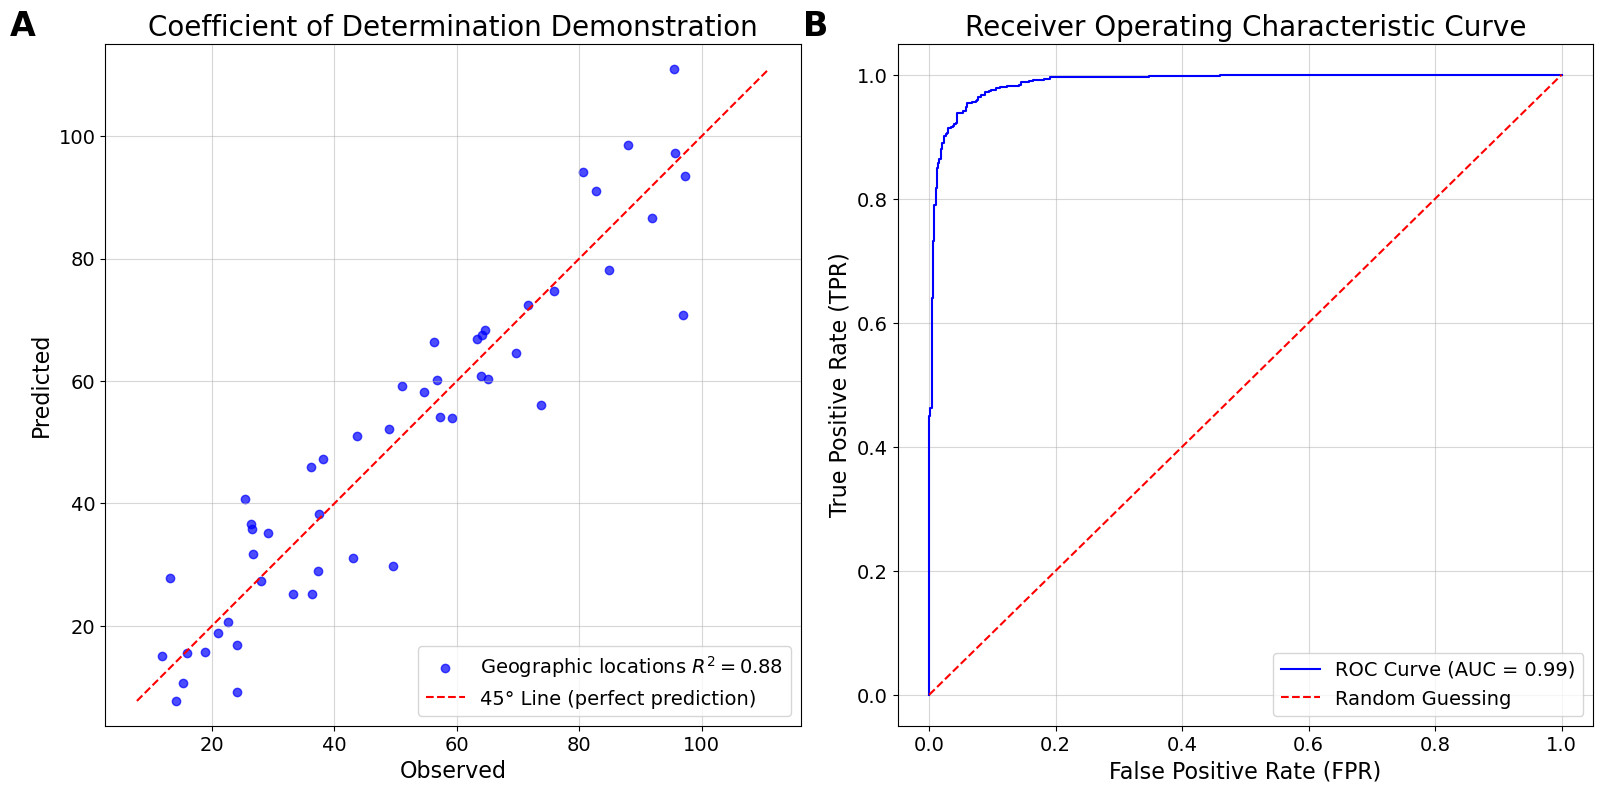

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, roc_curve, roc_auc_score

# Data for plot A
np.random.seed(42)
observed = np.random.uniform(10, 100, 50)
predicted = observed + np.random.normal(0, 10, 50)
r2 = r2_score(observed, predicted)
line = np.linspace(
    min(observed.min(), predicted.min()), max(observed.max(), predicted.max()), 100
)

# Data for plot B
y_true = np.random.randint(0, 2, 1000)
y_scores = np.where(
    y_true == 1, np.random.normal(0.7, 0.1, 1000), np.random.normal(0.4, 0.1, 1000)
)
y_scores = np.clip(y_scores, 0, 1)
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

# Define font sizes
title_fontsize = 20
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14
subplot_label_fontsize = 24

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot A: R² Demonstration
axes[0].scatter(
    observed,
    predicted,
    color="blue",
    label=f"Geographic locations $R^2 = {r2:.2f}$",
    alpha=0.7,
)
axes[0].plot(
    line, line, color="red", linestyle="--", label="45° Line (perfect prediction)"
)
axes[0].set_xlabel("Observed", fontsize=label_fontsize)
axes[0].set_ylabel("Predicted", fontsize=label_fontsize)
axes[0].set_title("Coefficient of Determination Demonstration", fontsize=title_fontsize)
axes[0].legend(loc="lower right", fontsize=legend_fontsize)
axes[0].grid(alpha=0.5)
axes[0].axis("equal")

# Add subplot label 'A' to Plot A
axes[0].text(
    -0.1,
    1.05,
    "A",
    transform=axes[0].transAxes,
    fontsize=subplot_label_fontsize,
    fontweight="bold",
    va="top",
    ha="right",
)

# Increase tick label sizes for Plot A
axes[0].tick_params(axis="both", which="major", labelsize=tick_fontsize)

# Plot B: ROC Curve
axes[1].plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {auc:.2f})")
axes[1].plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guessing")
axes[1].set_xlabel("False Positive Rate (FPR)", fontsize=label_fontsize)
axes[1].set_ylabel("True Positive Rate (TPR)", fontsize=label_fontsize)
axes[1].set_title("Receiver Operating Characteristic Curve", fontsize=title_fontsize)
axes[1].legend(fontsize=legend_fontsize)
axes[1].grid(alpha=0.5)

# Add subplot label 'B' to Plot B
axes[1].text(
    -0.1,
    1.05,
    "B",
    transform=axes[1].transAxes,
    fontsize=subplot_label_fontsize,
    fontweight="bold",
    va="top",
    ha="right",
)

# Increase tick label sizes for Plot B
axes[1].tick_params(axis="both", which="major", labelsize=tick_fontsize)

# Adjust layout and show the combined figure
plt.tight_layout()
# Save the figure to the 'images' folder
output_path = "../../images/R2_ROC_side_by_side_plots.png"
plt.savefig(output_path, dpi=300)
plt.show()

## Area of grid cells global

Number of grid cells created: 64800
Area range in square kilometers: 0.01 - 1.24
Natural Earth dataset already downloaded.
Extraction complete.


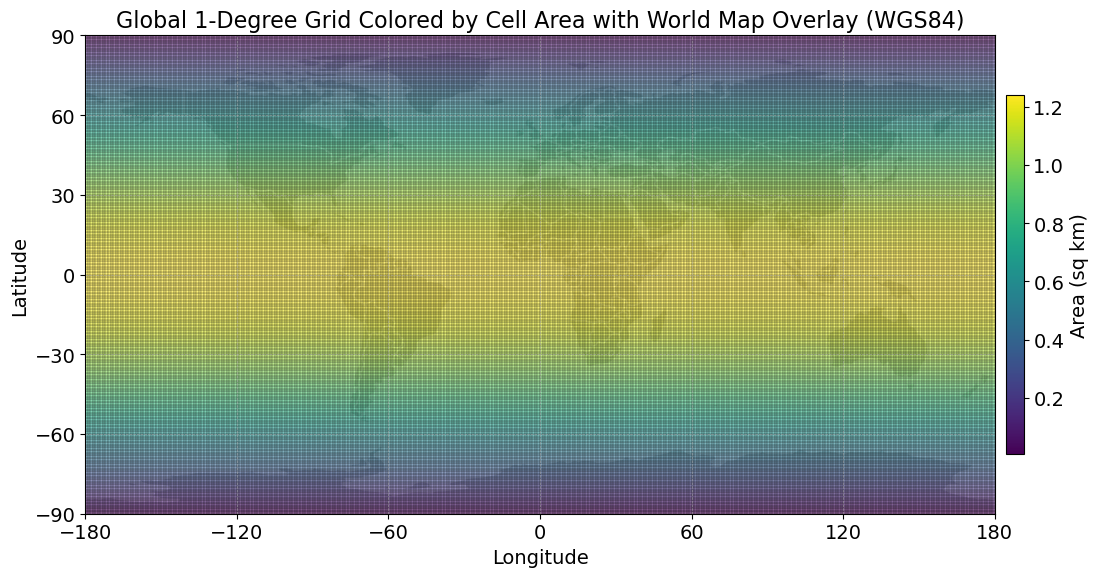

In [35]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import numpy as np
import requests
import zipfile
import io
import os

# Make text larger
plt.rcParams.update(
    {
        "font.size": 14,  # Base font size
        "axes.titlesize": 16,  # Axes title size
        "axes.labelsize": 14,  # Axes label size
        "legend.fontsize": 14,  # Legend text size
        "xtick.labelsize": 14,  # X-axis tick label size
        "ytick.labelsize": 14,  # Y-axis tick label size
    }
)

# 1. Create a global 1-degree resolution grid in WGS84

# Define the range for longitude and latitude
lon_min, lon_max = -180, 180
lat_min, lat_max = -90, 90
resolution = 1  # degree

# Generate the list of longitude and latitude edges
lon_edges = np.arange(lon_min, lon_max, resolution)
lat_edges = np.arange(lat_min, lat_max, resolution)

# Create a list to hold all grid cell polygons
polygons = []
for lon in lon_edges:
    for lat in lat_edges:
        # Create a box for each grid cell
        polygons.append(box(lon, lat, lon + resolution, lat + resolution))

# Create a GeoDataFrame with WGS84 CRS
grid_wgs84 = gpd.GeoDataFrame({"geometry": polygons})
grid_wgs84.set_crs(epsg=4326, inplace=True)

print(f"Number of grid cells created: {len(grid_wgs84)}")

# 2. Reproject the grid to an equal-area projection for accurate area calculation

# Choose an equal-area CRS. Mollweide projection is suitable for global equal-area representation.
equal_area_crs = "ESRI:54009"

# Reproject the grid to the equal-area CRS
grid_equal_area = grid_wgs84.to_crs(equal_area_crs)

# 3. Calculate the area of each grid cell
grid_wgs84["area_sqm"] = grid_equal_area["geometry"].area
grid_wgs84["area_sqkm"] = grid_wgs84["area_sqm"] / (1e6 * 10_000)
print(
    f"Area range in square kilometers: {grid_wgs84['area_sqkm'].min():.2f} - {grid_wgs84['area_sqkm'].max():.2f}"
)

# 4. Overlay a basic world map for geographic context

# Since geopandas.datasets.get_path is deprecated, we'll manually download the 'naturalearth_lowres' dataset
naturalearth_url = (
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
zip_path = os.path.join(data_dir, "ne_110m_admin_0_countries.zip")

# Download the dataset if it doesn't already exist
if not os.path.exists(zip_path):
    print("Downloading Natural Earth 'naturalearth_lowres' dataset...")
    response = requests.get(naturalearth_url)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            f.write(response.content)
        print("Download complete.")
    else:
        raise Exception(f"Failed to download data. Status code: {response.status_code}")
else:
    print("Natural Earth dataset already downloaded.")

# Extract the zip file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)
    print("Extraction complete.")

# Identify the extracted shapefile path
shapefile_path = os.path.join(data_dir, "ne_110m_admin_0_countries.shp")

# Load the world map using GeoPandas
world = gpd.read_file(shapefile_path)

# 5. Plot the WGS84 grid with cells colored by area and grid boundaries in thin black lines

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Reduce white space in the margins
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Plot the world map first
world.plot(ax=ax, color="lightgrey", edgecolor="white")

# Plot the grid on top
grid_wgs84.plot(
    column="area_sqkm",
    ax=ax,
    cmap="viridis",
    linewidth=0.25,  # Thin lines for grid boundaries
    edgecolor="black",
    alpha=0.6,  # Semi-transparent grid cells
    legend=True,
    legend_kwds={
        "label": "Area (sq km)",
        "orientation": "vertical",
        "shrink": 0.75,
        "pad": 0.01,  
    }
)

ax.set_title("Global 1-Degree Grid Colored by Cell Area with World Map Overlay (WGS84)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Customize grid ticks
ax.set_xticks(np.arange(-180, 181, 60))
ax.set_yticks(np.arange(-90, 91, 30))
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Let matplotlib automatically scale the axis
ax.set_aspect("auto")
ax.margins(0)

# Use tight_layout for a final nudge on spacing
plt.tight_layout()

# Save the figure
output_path = "../../images/global_1_degree_grid_wgs84_area.png"
plt.savefig(output_path, dpi=300)
plt.show()
